In [1]:
import os
os.chdir("../")
%load_ext autoreload
%autoreload 2

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from prior import VQVAEPrior
from experiment import VAEXperiment

from easydict import EasyDict as edict
from analysis.image import show_image
from datamodules import DATAMODULES

# Load Prior Model

In [3]:
prior_ckpt_path = "model_logs/prior/pixel_cnn/CIFAR10/pixel_cnn_test/epoch=50-val_loss_epoch=4.64.ckpt"
prior_ckpt = torch.load(prior_ckpt_path, map_location="cpu")
prior_hparams = edict(prior_ckpt["hyper_parameters"])
prior = VQVAEPrior(prior_hparams)
prior.load_state_dict(prior_ckpt["state_dict"])



Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d


<All keys matched successfully>

In [4]:

_ = prior.cuda()
_ = prior.eval()

In [5]:
samples = prior.generate_samples(batch_size=40)

# Datasets

In [6]:
import torchvision.transforms as T
from torchvision.datasets import CIFAR10, SVHN, Omniglot, CelebA



In [23]:
datasets_root = "/home/nazir/datasets"

transform_cifar = T.Compose([
    T.ToTensor(),
    T.Normalize(prior_hparams.DATA.MEAN, prior_hparams.DATA.STD)
])


transform_omniglot = T.Compose([
    T.ToTensor(),
    T.Lambda(lambda x: x.repeat(3, 1, 1)),
    T.Resize(32),
    T.Normalize(prior_hparams.DATA.MEAN, prior_hparams.DATA.STD)
])

transform_celeba = T.Compose([
    T.ToTensor(),
    T.Resize((32, 32)),
    T.Normalize(prior_hparams.DATA.MEAN, prior_hparams.DATA.STD)
])


cifar_train = CIFAR10(root=datasets_root, train=True, download=True, transform=transform_cifar)
cifar_test = CIFAR10(root=datasets_root, train=False, download=True, transform=transform_cifar)

svhn_test = SVHN(root=datasets_root, split="test", download=True, transform=transform_cifar)
omniglot_test = Omniglot(root=datasets_root, background=True, download=True, transform=transform_omniglot)
celeba_test = CelebA(root=datasets_root, split="test", download=True, transform=transform_celeba)

datasets = edict(
    CIFAR10_train=cifar_train,
    CIFAR10=cifar_test,
    SVHN=svhn_test,
    Omniglot=omniglot_test, 
    CelebA=celeba_test
)

Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: /home/nazir/datasets/test_32x32.mat
Files already downloaded and verified
Files already downloaded and verified


# Validating Likelihood Computation

**conclusion** : both versions of likelihood are the same, however, v2 is normalized by the number of input tokens and is negative, that's all.

In [41]:
from likelihood import (
    compute_log_likelihood, 
    compute_log_likelihood_v2, 
    compute_dataset_log_likelihood,
    compute_dataset_log_likelihood_batched,
    get_perplexity
)

In [9]:
x, y = cifar_test[0]



In [16]:
likelihood = compute_log_likelihood(prior, x, y)
likelihood_v2 = compute_log_likelihood_v2(prior, x, y)

In [18]:
likelihood / 64, likelihood_v2

(tensor([-5.5615], device='cuda:0'), tensor(5.5615, device='cuda:0'))

# Compute Likelihoods

In [31]:
cifar_likelihoods = compute_dataset_log_likelihood(prior, cifar_test)
svhn_likelihoods = compute_dataset_log_likelihood(prior, svhn_test)
omniglot_likelihoods = compute_dataset_log_likelihood(prior, omniglot_test, arbitrary_cls=0)
celeba_likelihoods = compute_dataset_log_likelihood(prior, celeba_test, arbitrary_cls=0)

100%|██████████| 10000/10000 [01:24<00:00, 118.06it/s]


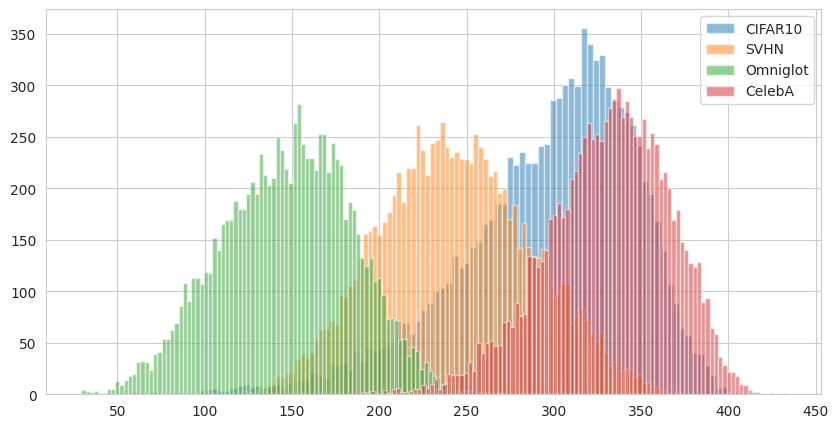

In [34]:
# plot the densities of the likelihoods
plt.figure(figsize=(10, 5))
plt.hist(-1*cifar_likelihoods, bins=100, alpha=0.5, label="CIFAR10")
plt.hist(-1*svhn_likelihoods, bins=100, alpha=0.5, label="SVHN")
plt.hist(-1*omniglot_likelihoods, bins=100, alpha=0.5, label="Omniglot")
plt.hist(-1*celeba_likelihoods, bins=100, alpha=0.5, label="CelebA")
plt.legend()
plt.show()

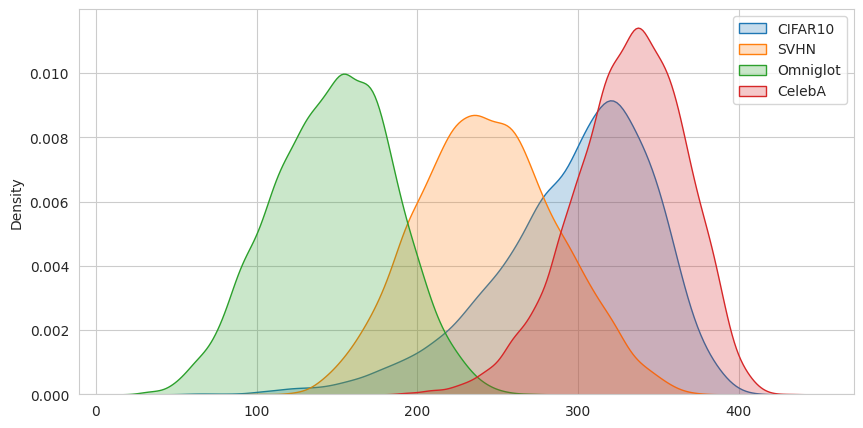

In [38]:
# plot the densities of the likelihoods using seaborn library

sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))
sns.kdeplot(-1*cifar_likelihoods, fill=True, label="CIFAR10")
sns.kdeplot(-1*svhn_likelihoods, fill=True, label="SVHN")
sns.kdeplot(-1*omniglot_likelihoods, fill=True, label="Omniglot")
sns.kdeplot(-1*celeba_likelihoods, fill=True, label="CelebA")
plt.legend()
plt.show()

## Check effect of different conditioning for OoD Datasets

100%|██████████| 10000/10000 [01:23<00:00, 119.55it/s]


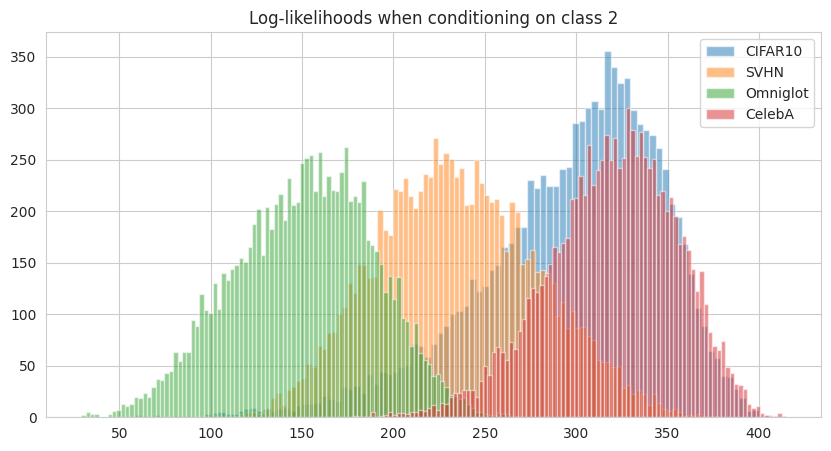

100%|██████████| 10000/10000 [01:24<00:00, 118.43it/s]


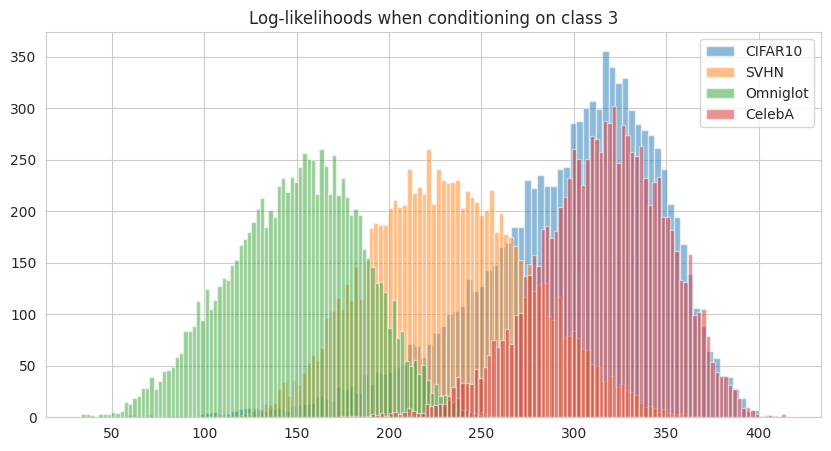

100%|██████████| 10000/10000 [01:24<00:00, 118.28it/s]


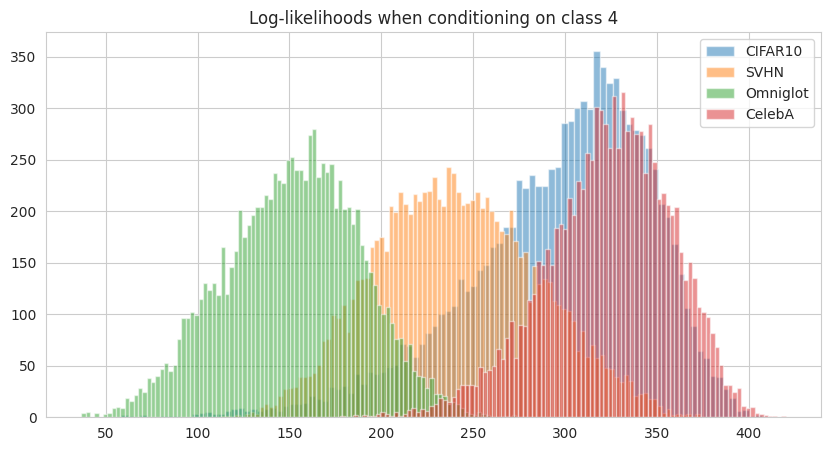

100%|██████████| 10000/10000 [01:27<00:00, 114.25it/s]


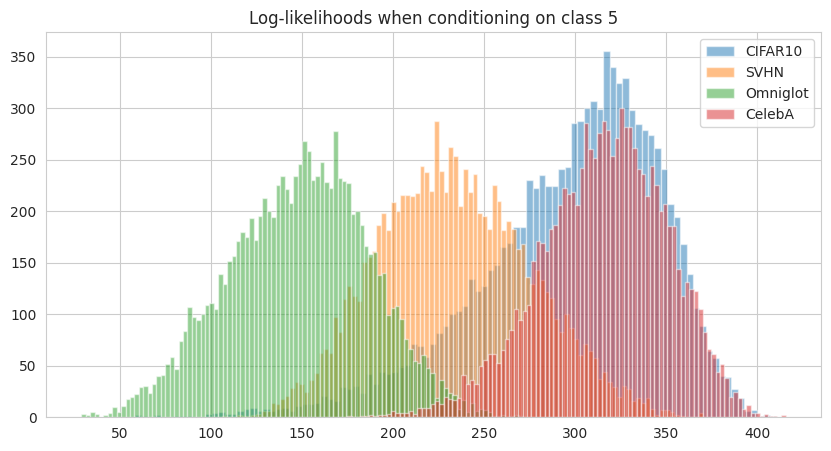

100%|██████████| 10000/10000 [01:27<00:00, 114.46it/s]


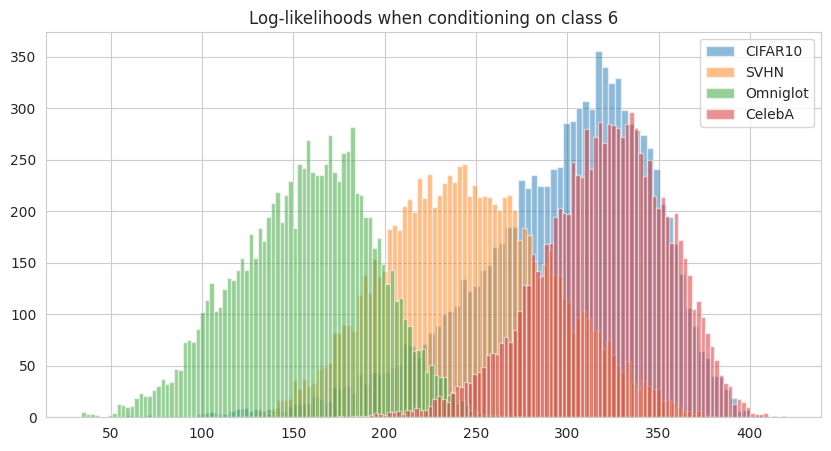

100%|██████████| 10000/10000 [01:24<00:00, 118.66it/s]


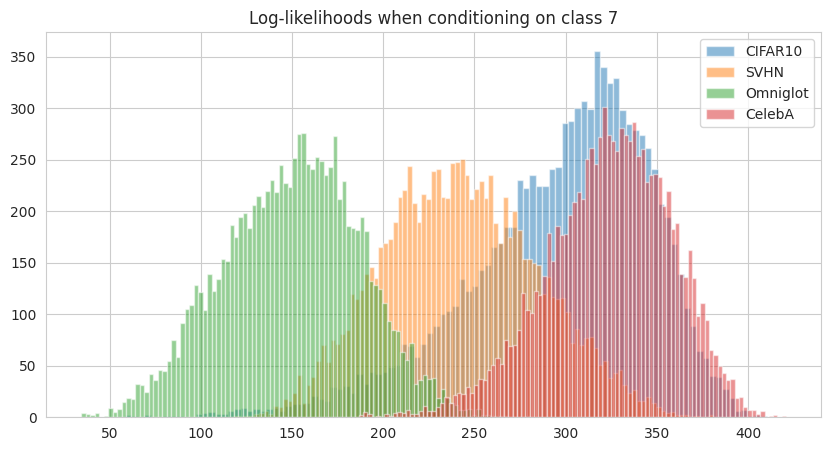

100%|██████████| 10000/10000 [01:35<00:00, 104.32it/s]


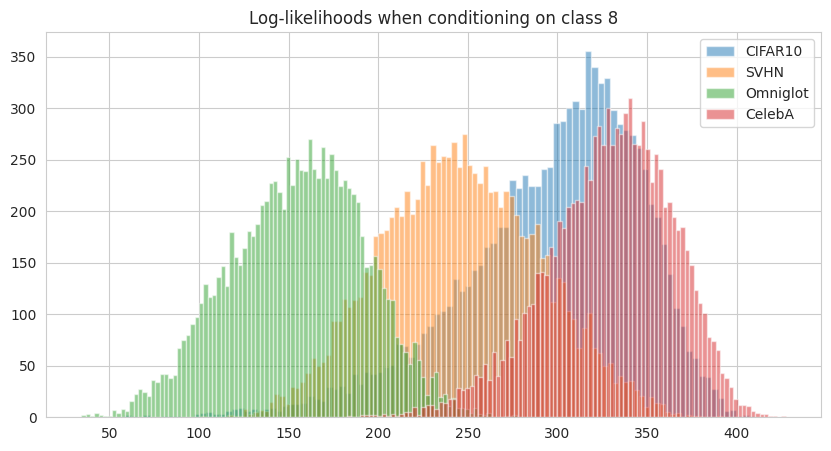

100%|██████████| 10000/10000 [01:39<00:00, 100.46it/s]


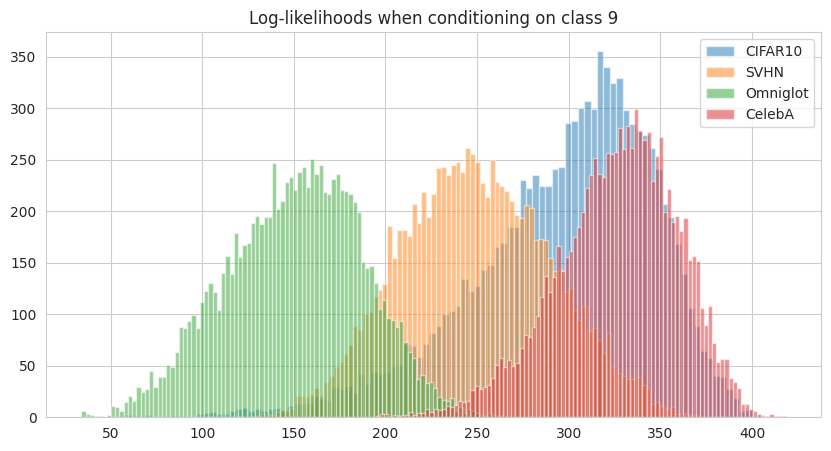

In [40]:
for cls in range(2, 10):
    
    svhn_likelihoods_cls = compute_dataset_log_likelihood(prior, svhn_test, arbitrary_cls=cls)
    omniglot_likelihoods_cls = compute_dataset_log_likelihood(prior, omniglot_test, arbitrary_cls=cls)
    celeba_likelihoods_cls = compute_dataset_log_likelihood(prior, celeba_test, arbitrary_cls=cls)

    plt.figure(figsize=(10, 5))
    plt.hist(-1*cifar_likelihoods, bins=100, alpha=0.5, label="CIFAR10")
    plt.hist(svhn_likelihoods_cls, bins=100, alpha=0.5, label="SVHN")
    plt.hist(omniglot_likelihoods_cls, bins=100, alpha=0.5, label="Omniglot")
    plt.hist(celeba_likelihoods_cls, bins=100, alpha=0.5, label="CelebA")
    plt.legend()
    plt.title("Log-likelihoods when conditioning on class {}".format(cls))
    plt.show()

# Perplexities

In [42]:
from tqdm import tqdm

In [43]:
cifar_perplexity = []

for i in tqdm(range(len(cifar_test))):
    x, y = cifar_test[i]
    p = get_perplexity(x.cuda().unsqueeze(0), torch.tensor(y).cuda().unsqueeze(0))
    cifar_perplexity.append(p.cpu().item())

svhn_perplexity = []
for i in tqdm(range(min(len(svhn_test), 10000))):

    x, y = svhn_test[i]

    p = get_perplexity(x.cuda().unsqueeze(0), torch.tensor(y).cuda().unsqueeze(0))
    svhn_perplexity.extend([p.cpu().item()])


omniglot_perplexity = []
for i in tqdm(range(min(len(omniglot_test), 10000))):

    x, y = omniglot_test[i]

    p = get_perplexity(x.cuda().unsqueeze(0), torch.tensor(0).cuda().unsqueeze(0))
    omniglot_perplexity.extend([p.cpu().item()])

celeba_perplexity = []
for i in tqdm(range(min(len(celeba_test), 10000))):

    x, y = celeba_test[i]

    p = get_perplexity(x.cuda().unsqueeze(0), torch.tensor(0).cuda().unsqueeze(0))
    celeba_perplexity.extend([p.cpu()])

  0%|          | 0/10000 [00:00<?, ?it/s]


UnboundLocalError: local variable 'y' referenced before assignment